c:\Users\sebas\OneDrive\Escritorio\TFM-Ciencia de datos\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sebas\OneDrive\Escritorio\TFM-Ciencia de datos\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sebas\OneDrive\Escritorio\TFM-Ciencia de datos\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sebas\OneDrive\Escritorio\TFM-Ciencia de datos\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sebas\OneDrive\Escritorio\TFM-Ciencia de datos\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
 

✅ Modelo guardado como c:\Users\sebas\OneDrive\Escritorio\TFM-Ciencia de datos\GBPUSD\best_model_walkforward_weekly_dt_fullparams.joblib

📊 Métricas promedio generales:
🔹 F1 Score promedio:      0.8659
🔹 Accuracy promedio:      0.8914
🔹 Precision promedio:     0.9013
🔹 Recall promedio:        0.9605


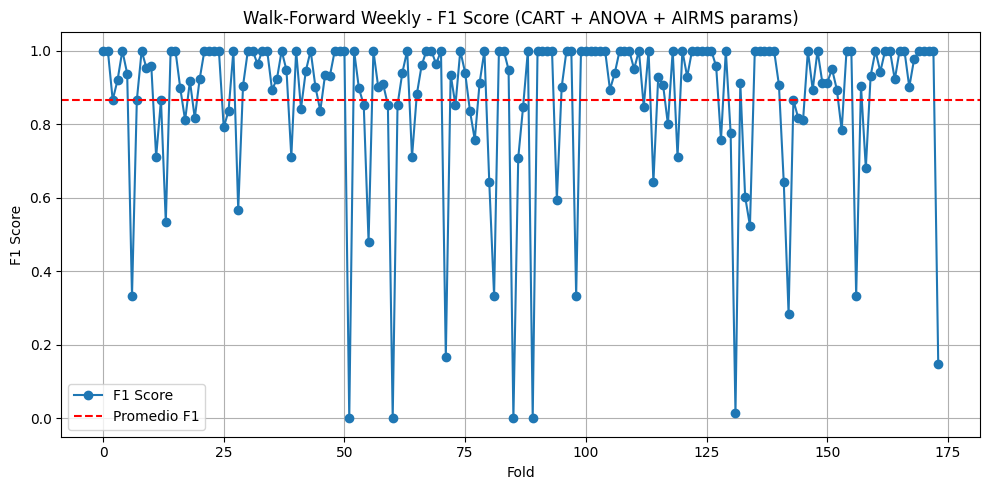

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import joblib
import csv

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    precision_score, recall_score
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

# Ignorar advertencias de características constantes
warnings.filterwarnings("ignore", category=UserWarning, message="Features.*are constant")

# === Ruta base para Jupyter Notebook (carpeta actual del notebook) ===
base_path = os.getcwd()
csv_path = os.path.join(base_path, "df_train.csv")

# 1. Cargar datos
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['week'] = df['time'].dt.isocalendar().week
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday

# 2. Filtrar y preparar
df = df[(df['signal'] == 1) & (df['label'].notna())].copy()
df['label'] = df['label'].astype(int)

features_cols = [
    'close',
    'sma_200_vs_100', 'sma_50_vs_25', 'rsi_14', 'acceleration_12',
    'macd', 'stoch_k', 'momentum_12', 'bb_middle', 'bb_upper',
    'bb_lower', 'weighted_close', 'poc_12', 'high_channel_20',
    'low_channel_20', 'abs_diff_mrb_vs_close',
    'last_signal_price_1', 'last_signal_price_2',
    'last_signal_price_3', 'last_signal_price_4',
    'last_signal_price_5', 'hour', 'weekday'
]

# 3. Hiperparámetros para CART con SelectKBest
param_dist = {
    "selectk__k": list(range(5, 21)),
    "clf__criterion": ["gini", "entropy"],
    "clf__splitter": ["best", "random"],
    "clf__max_depth": [2, 3, 4],
    "clf__min_samples_split": [10, 20],
    "clf__min_samples_leaf": [10, 20],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__ccp_alpha": np.linspace(0.01, 0.1, 5),
    "clf__class_weight": [None, "balanced"]
}

# 4. Walk-forward semanal
df['year_week'] = df['time'].dt.strftime('%Y-%U')
unique_periods = sorted(df['year_week'].unique())
min_train_weeks = 12

scores = []
accs = []
precs = []
recalls = []
final_model = None

results_path = os.path.join(base_path, "results_walkforward_weekly_dt_fullparams.csv")

with open(results_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Periodo", "F1_Score", "Accuracy", "Precision", "Recall", "Best_Params"])

    for i in range(min_train_weeks, len(unique_periods) - 1):
        train_periods = unique_periods[i - min_train_weeks:i]
        test_period = unique_periods[i]

        df_train = df[df['year_week'].isin(train_periods)].copy()
        df_test = df[df['year_week'] == test_period].copy()

        if df_train.empty or df_test.empty:
            continue

        X_train = df_train[features_cols].fillna(0)
        y_train = df_train['label']
        X_test = df_test[features_cols].fillna(0)
        y_test = df_test['label']

        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('selectk', SelectKBest(score_func=f_classif)),
            ('clf', DecisionTreeClassifier(random_state=42))
        ])

        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_dist,
            scoring='f1_weighted',
            cv=StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42),
            n_iter=30,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train, y_train)
        best_params = search.best_params_

        final_pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('selectk', SelectKBest(score_func=f_classif, k=best_params["selectk__k"])),
            ('clf', DecisionTreeClassifier(
                criterion=best_params["clf__criterion"],
                splitter=best_params["clf__splitter"],
                max_depth=best_params["clf__max_depth"],
                min_samples_split=best_params["clf__min_samples_split"],
                min_samples_leaf=best_params["clf__min_samples_leaf"],
                max_features=best_params["clf__max_features"],
                ccp_alpha=best_params["clf__ccp_alpha"],
                class_weight=best_params["clf__class_weight"],
                random_state=42
            ))
        ])

        final_pipeline.fit(X_train, y_train)
        y_pred = final_pipeline.predict(X_test)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        scores.append(f1)
        accs.append(acc)
        precs.append(prec)
        recalls.append(rec)

        writer.writerow([test_period, f1, acc, prec, rec, best_params])
        final_model = final_pipeline

# Guardar modelo final
model_path = os.path.join(base_path, "best_model_walkforward_weekly_dt_fullparams.joblib")

if final_model is not None:
    joblib.dump(final_model, model_path)
    print(f"✅ Modelo guardado como {model_path}")

# Visualización de métricas promedio
print("\n📊 Métricas promedio generales:")
print(f"🔹 F1 Score promedio:      {np.mean(scores):.4f}")
print(f"🔹 Accuracy promedio:      {np.mean(accs):.4f}")
print(f"🔹 Precision promedio:     {np.mean(precs):.4f}")
print(f"🔹 Recall promedio:        {np.mean(recalls):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(scores, marker='o', label='F1 Score')
plt.axhline(np.mean(scores), color='red', linestyle='--', label='Promedio F1')
plt.title('Walk-Forward Weekly - F1 Score (CART + ANOVA + AIRMS params)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


